In [3]:
options(tidyverse.quiet = TRUE) 
library(tidyverse, warn.conflicts = FALSE)

library(badr)
load_julia_package()

Loaded julia package 'bad' successfully.



In [4]:
p0    <- .2
alpha <- .05
p1    <- .4
beta  <- .2
mcr   <- .3

prior <- (0.2*Beta(1, 1) + 0.8*Beta_mu_sd(.35, .1) ) <= 0.7

In [5]:
design <- Problem(
        minimise( SampleSize(prior) ),
        Power(prior %|% p0) <= alpha,
        Power(prior >= mcr) >= 1 - beta,
        label = 'pragmatic prior'
    ) %>%
    optimise_design(verbosity = 0)

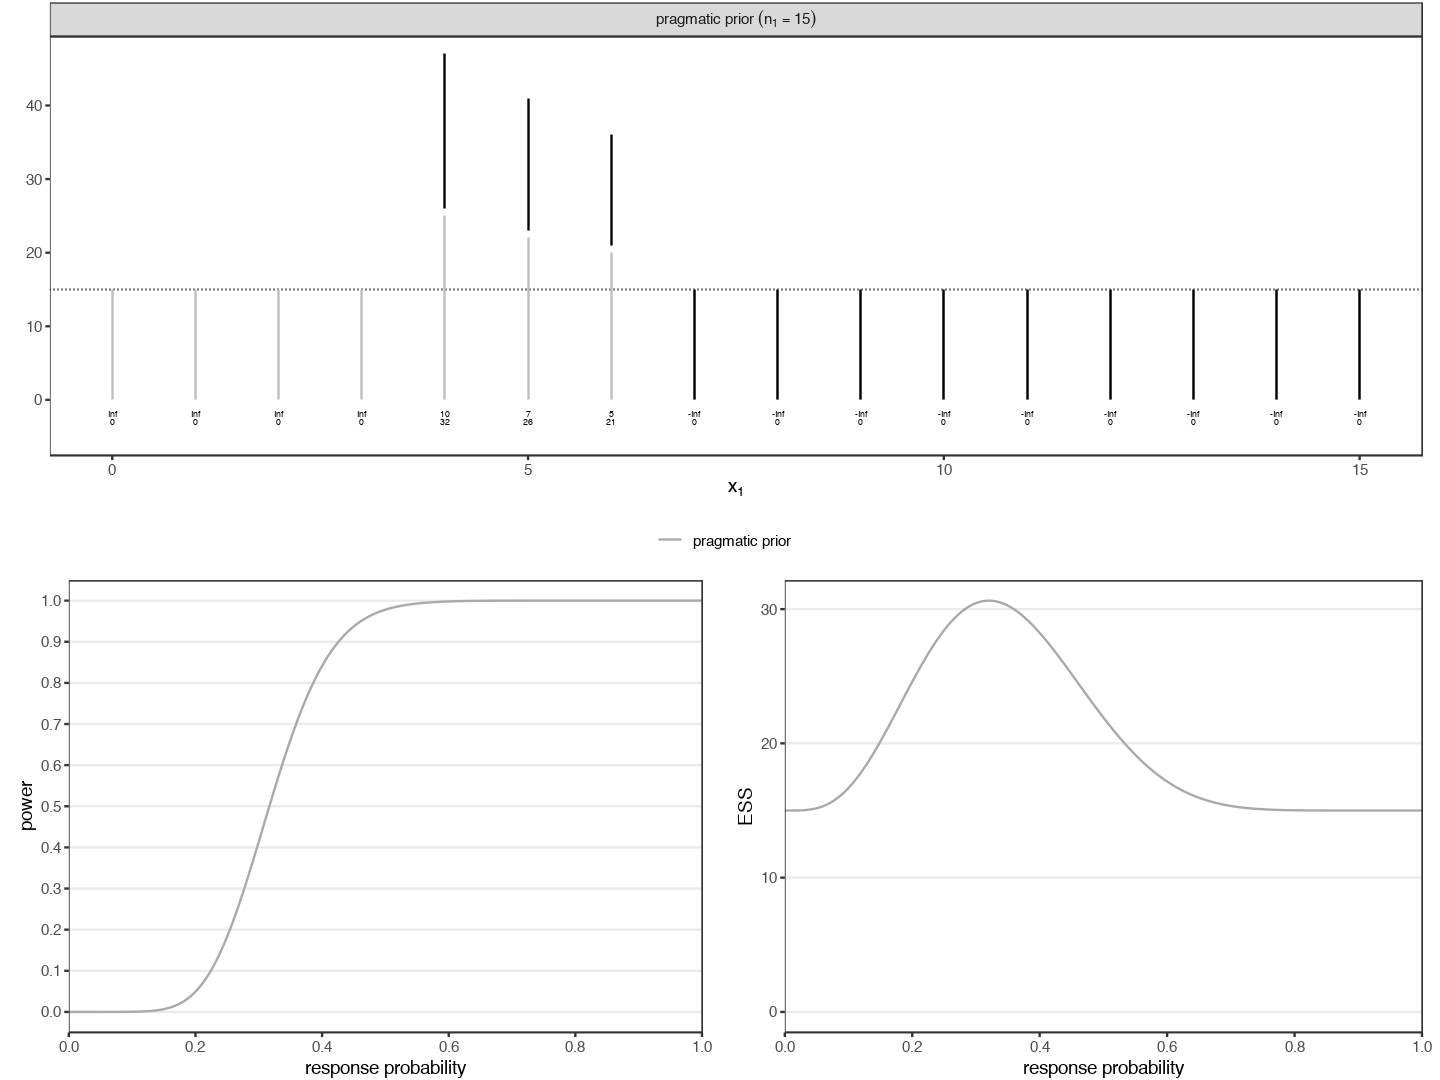

In [23]:
options(repr.plot.width = 12, repr.plot.height = 9)


plt_design <- plot_compare_designs(
    design, 
    args_design_plot = list(yexpandlower = .125)
)

design_plot

In [9]:
tbl_estimators <- tibble(
        MLE  = list(MaximumLikelihoodEstimator()),
        PMEJ = list(PosteriorMeanPrecalculated(JeffreysPrior(design), design)),
        PMEP = list(PosteriorMeanPrecalculated(prior, design)),
        RBE  = list(RaoBlackwellEstimator())
    ) %>%
    pivot_longer(
        everything(), values_to = 'estimator'
    ) %>%
    mutate(
        pvalue   = map(estimator, ~PValue(., design, p0, orientation = 'superiority')),
        interval = map2(name, estimator, function(estimator_name, estimator) {
            if (estimator_name == "PMEJ") return(
                    PosteriorCredibleInterval(JeffreysPrior(design), design, alpha)
                )
            if (estimator_name == "PMEP") return(
                    PosteriorCredibleInterval(prior, design, alpha)
                )
            ClopperPearsonInterval(EstimatorOrdering(estimator), design, alpha)
        })
    )

In [11]:
tbl_performance <- expand_grid(
        estimator = tbl_estimators$name,
        p         = seq(0, 1, .01)
    ) %>%
    mutate(
        data = map2(p, estimator,
            function(p, estimator_name) {
                estimator <- tbl_estimators %>%
                    filter(name == estimator_name) %>%
                    pull(estimator) %>%
                    .[[1]]
                tibble(
                    bias = bias(p, estimator, design),
                    RMSE = sqrt(mean_squared_error(p, estimator, design))
                )
            }
        )
    ) %>%
    unnest(data) %>%
    pivot_longer(c(bias, RMSE), names_to = 'quantity')

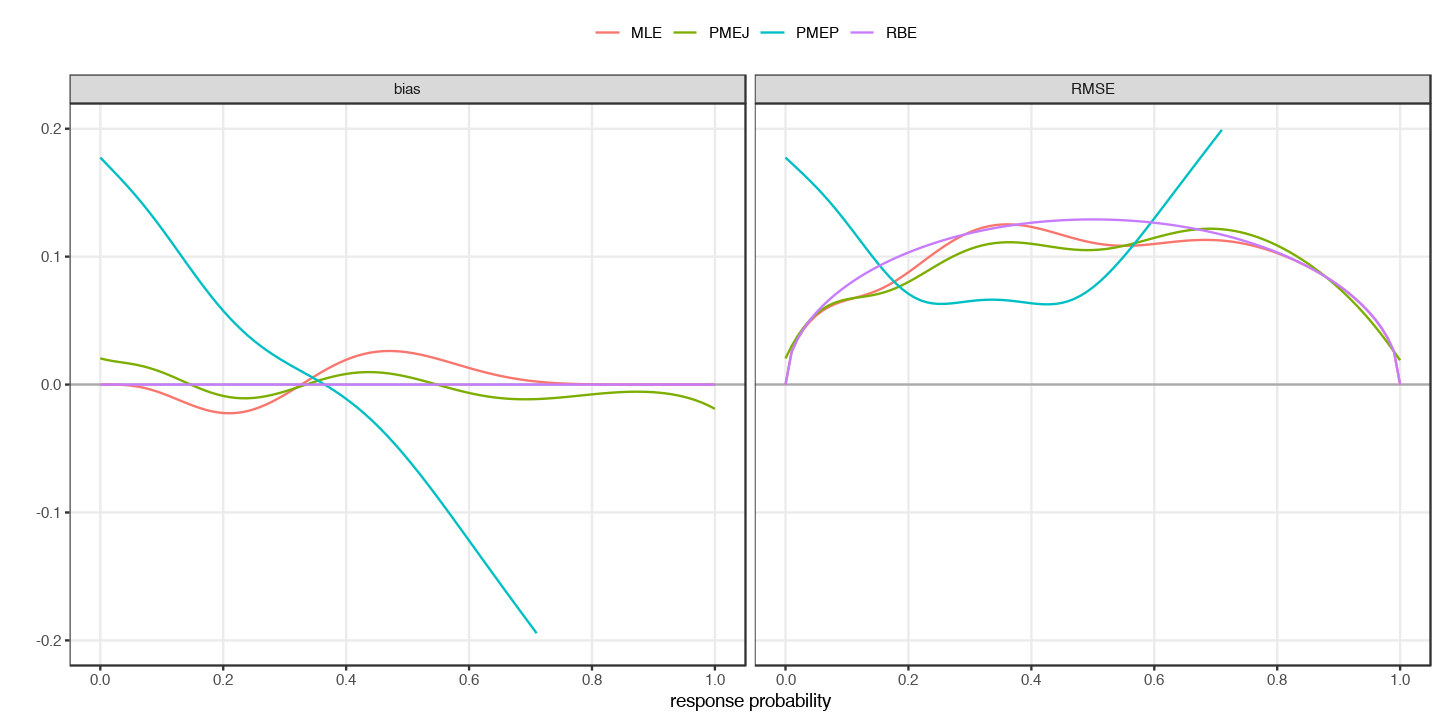

In [24]:
options(repr.plot.width = 12, repr.plot.height = 6)


plt_performance_comparison <- ggplot(
        tbl_performance %>% 
            filter(between(value, -.2, .2))
    ) +
    aes(p, value, color = estimator) +
    geom_hline(yintercept = 0, color = 'darkgray') +
    geom_line(size = .5) +
    scale_x_continuous('response probability', breaks = seq(0, 1, .2)) +
    scale_y_continuous('', limits = c(-.2, .2)) +
    scale_color_discrete('') +
    facet_wrap(~quantity) +
    theme_bw() +
    theme(
        legend.position  = 'top',
        panel.grid.minor = element_blank()
    )

plt_performance_comparison

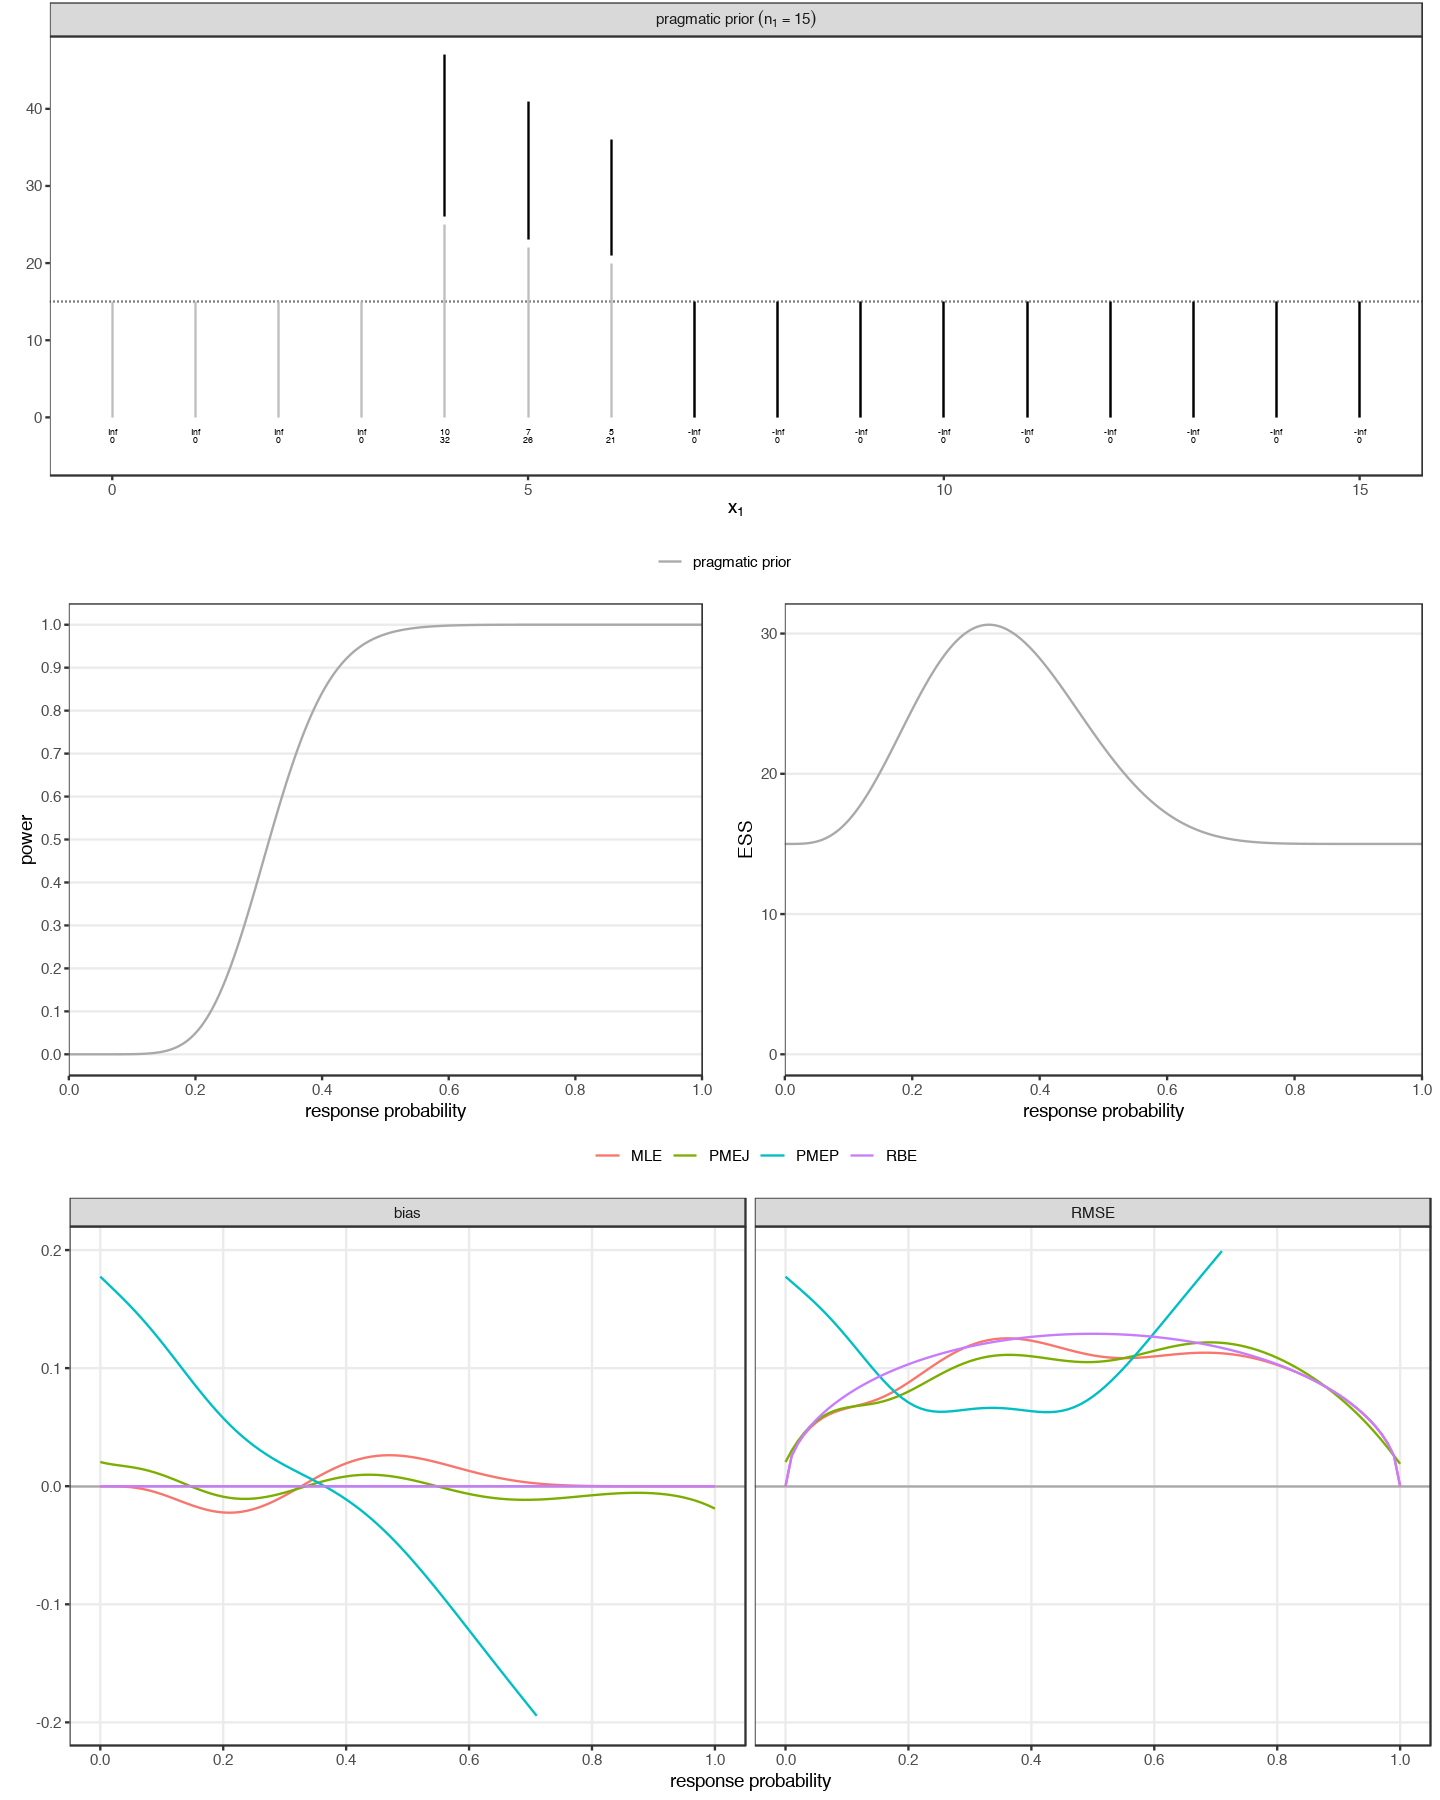

In [25]:
options(repr.plot.width = 12, repr.plot.height = 15)


cowplot::plot_grid(
    plt_design, 
    plt_performance_comparison,
    ncol = 1, 
    rel_heights = c(1.66, 1)
)

In [ ]:
ggsave("frequentist-inference-bias-rmse-performance.pdf", width = 7, height = 8)

In [26]:
XX <- sample_space(design)

In [27]:
# compute p-value probability mass in [p_min, p_max]
p_value_density <- function(p_min, p_max, probability, p_value) {
    XX %>%
    mutate(
        probability = probability,
        pvalue      = list(p_value)
    ) %>%
    mutate(
        pmf      = pmap_dbl( list(x1, x2, probability), ~pmf(design, ..1, ..2, ..3) ),
        p_value  = pmap_dbl( list(x1, x2, pvalue), ~get_p(..3, ..1, ..2) )
    ) %>%
    filter(p_min < p_value, p_value <= p_max) %>%
    select(p_value, probability, pmf) %>%
    group_by(probability, p_value) %>%
    summarize(pmf = sum(pmf)) %>%
    ungroup() %>%
    mutate(
        p_value_binned = cut(p_value, seq(0, 1, .01), labels = seq(.01, 1, .01))
    ) %>%
    summarize(
        pmf = sum(pmf)
    ) %>%
    ungroup() %>%
    pull(pmf) %>%
    .[[1]]
}

In [28]:
tbl_pvalues_density <- expand_grid(
        p_value     = seq(0, 1, .025),
        probability = seq(0, 1, .025),
        name        = tbl_estimators$name
    ) %>%
    mutate(
        pmf = pmap_dbl(
                list(p_value, probability, name),
                ~p_value_density(..1 - .0125, ..1 + .0125, ..2,
                                 filter(tbl_estimators, name == ..3)$pvalue[[1]] )
            )
    )

print(tbl_pvalues_density, n = 10)

# A tibble: 6,724 x 4
   p_value probability name       pmf
     <dbl>       <dbl> <chr>    <dbl>
 1       0       0     MLE   0.      
 2       0       0     PMEJ  0.      
 3       0       0     PMEP  0.      
 4       0       0     RBE   0.      
 5       0       0.025 MLE   8.39e-10
 6       0       0.025 PMEJ  8.39e-10
 7       0       0.025 PMEP  8.39e-10
 8       0       0.025 RBE   8.39e-10
 9       0       0.05  MLE   1.83e- 7
10       0       0.05  PMEJ  1.83e- 7
# … with 6,714 more rows


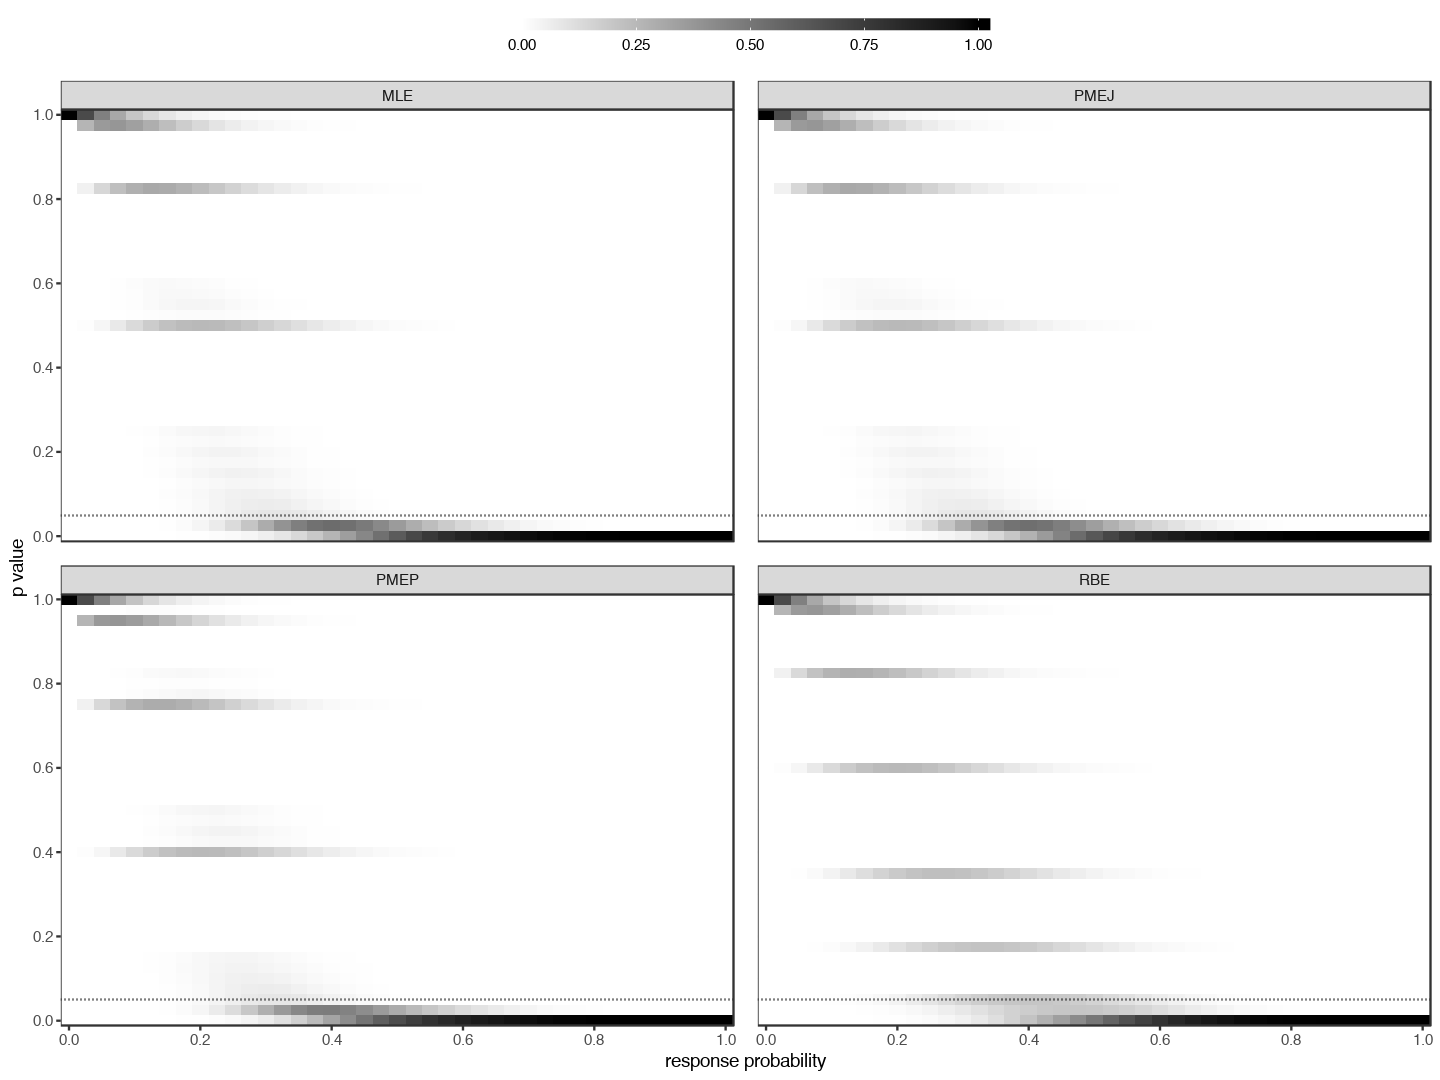

In [30]:
options(repr.plot.width = 12, repr.plot.height = 9)

plt_pval_density <- ggplot(tbl_pvalues_density) +
    geom_raster(aes(x = probability, y = p_value, fill = pmf)) +
    geom_hline(yintercept = alpha, linetype = 'dotted') +
    coord_cartesian(expand = FALSE) +
    scale_x_continuous('response probability', breaks = seq(0, 1, .2)) +
    scale_y_continuous('p value', breaks = seq(0, 1, .2)) +
    scale_fill_gradient('', low = 'white', high = 'black') +
    facet_wrap(~name) +
    theme_bw() +
    theme(
        panel.spacing     = unit(1, "lines"),
        legend.position   = 'top',
        legend.key.width  = grid::unit(4, 'lines'),
        legend.key.height = grid::unit(.5, 'lines')
    )

plt_pval_density

In [31]:
tbl_pval_dist <- XX %>%
    mutate(
        name      = list(tbl_estimators$name),
        pvalue    = list(tbl_estimators$pvalue)
    ) %>%
    unnest(c(name, pvalue)) %>%
    mutate(
        p_value  = pmap_dbl( list(x1, x2, pvalue), ~get_p(..3, ..1, ..2) )
    ) %>%
    select(-pvalue) %>%
    mutate(
        `p = 0.2` = pmf(design, x1, x2, 0.2),
        `p = 0.4` = pmf(design, x1, x2, 0.4)
    ) %>%
    pivot_longer(c(`p = 0.2`, `p = 0.4`), names_to = 'response probability', values_to = 'pmf') %>%
    select(-x1, -x2) %>%
    arrange(name, `response probability`, p_value) %>%
    group_by(name, `response probability`) %>%
    mutate(
        cdf = cumsum(pmf)
    )

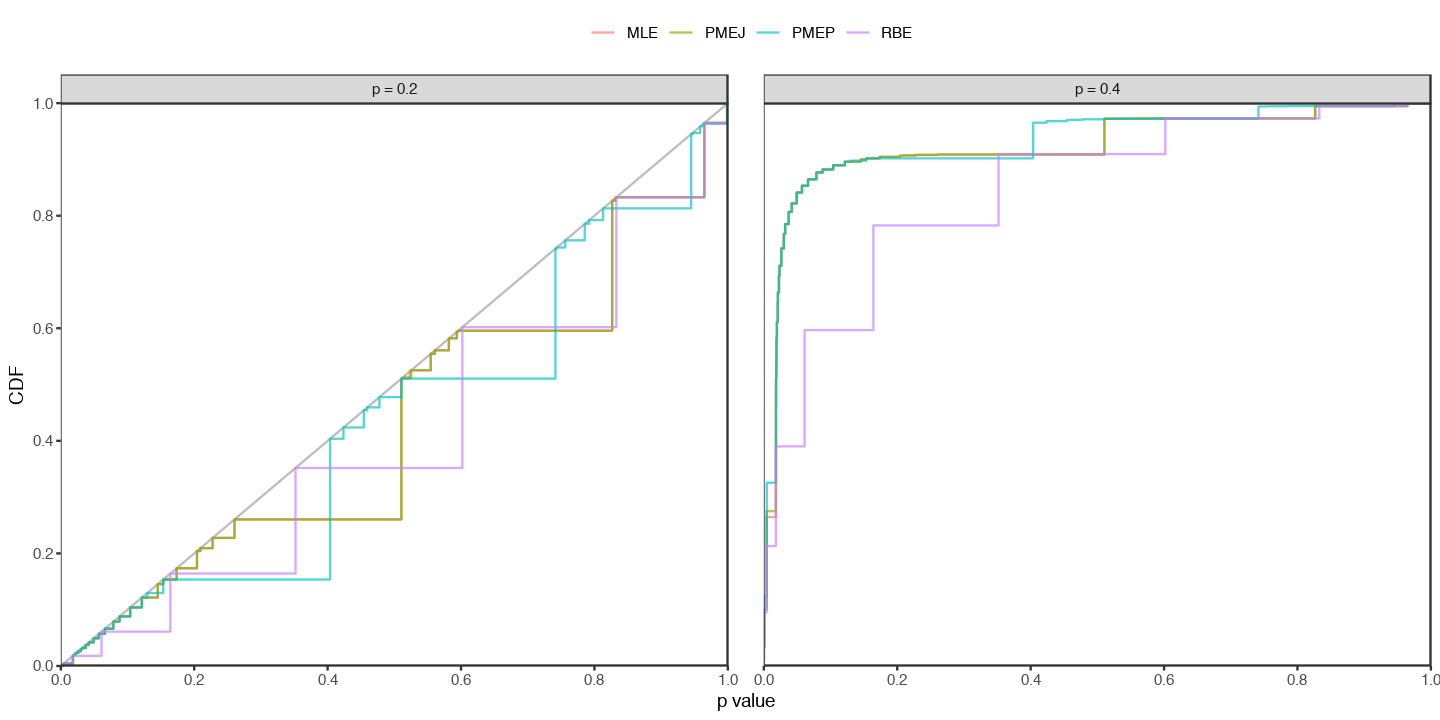

In [33]:
options(repr.plot.width = 12, repr.plot.height = 6)


plt_pval_cdf <- ggplot(tbl_pval_dist, aes(p_value, cdf)) +
    geom_line(color = 'gray', data = tibble(p_value = c(0, 1), cdf = c(0, 1),
                            'response probability' = "p = 0.2")) +
    geom_step(aes(color = name), alpha = .66) +
    facet_wrap(~`response probability`) +
    scale_color_discrete('') +
    scale_x_continuous('p value', breaks = seq(0, 1, .2)) +
    scale_y_continuous('CDF', breaks = seq(0, 1, .2), limits = c(0, 1)) +
    coord_cartesian(expand = FALSE) +
    theme_bw() +
    theme(
        legend.position = 'top',
        panel.grid      = element_blank(),
        panel.spacing   = unit(1.5, "lines")
    )

plt_pval_cdf

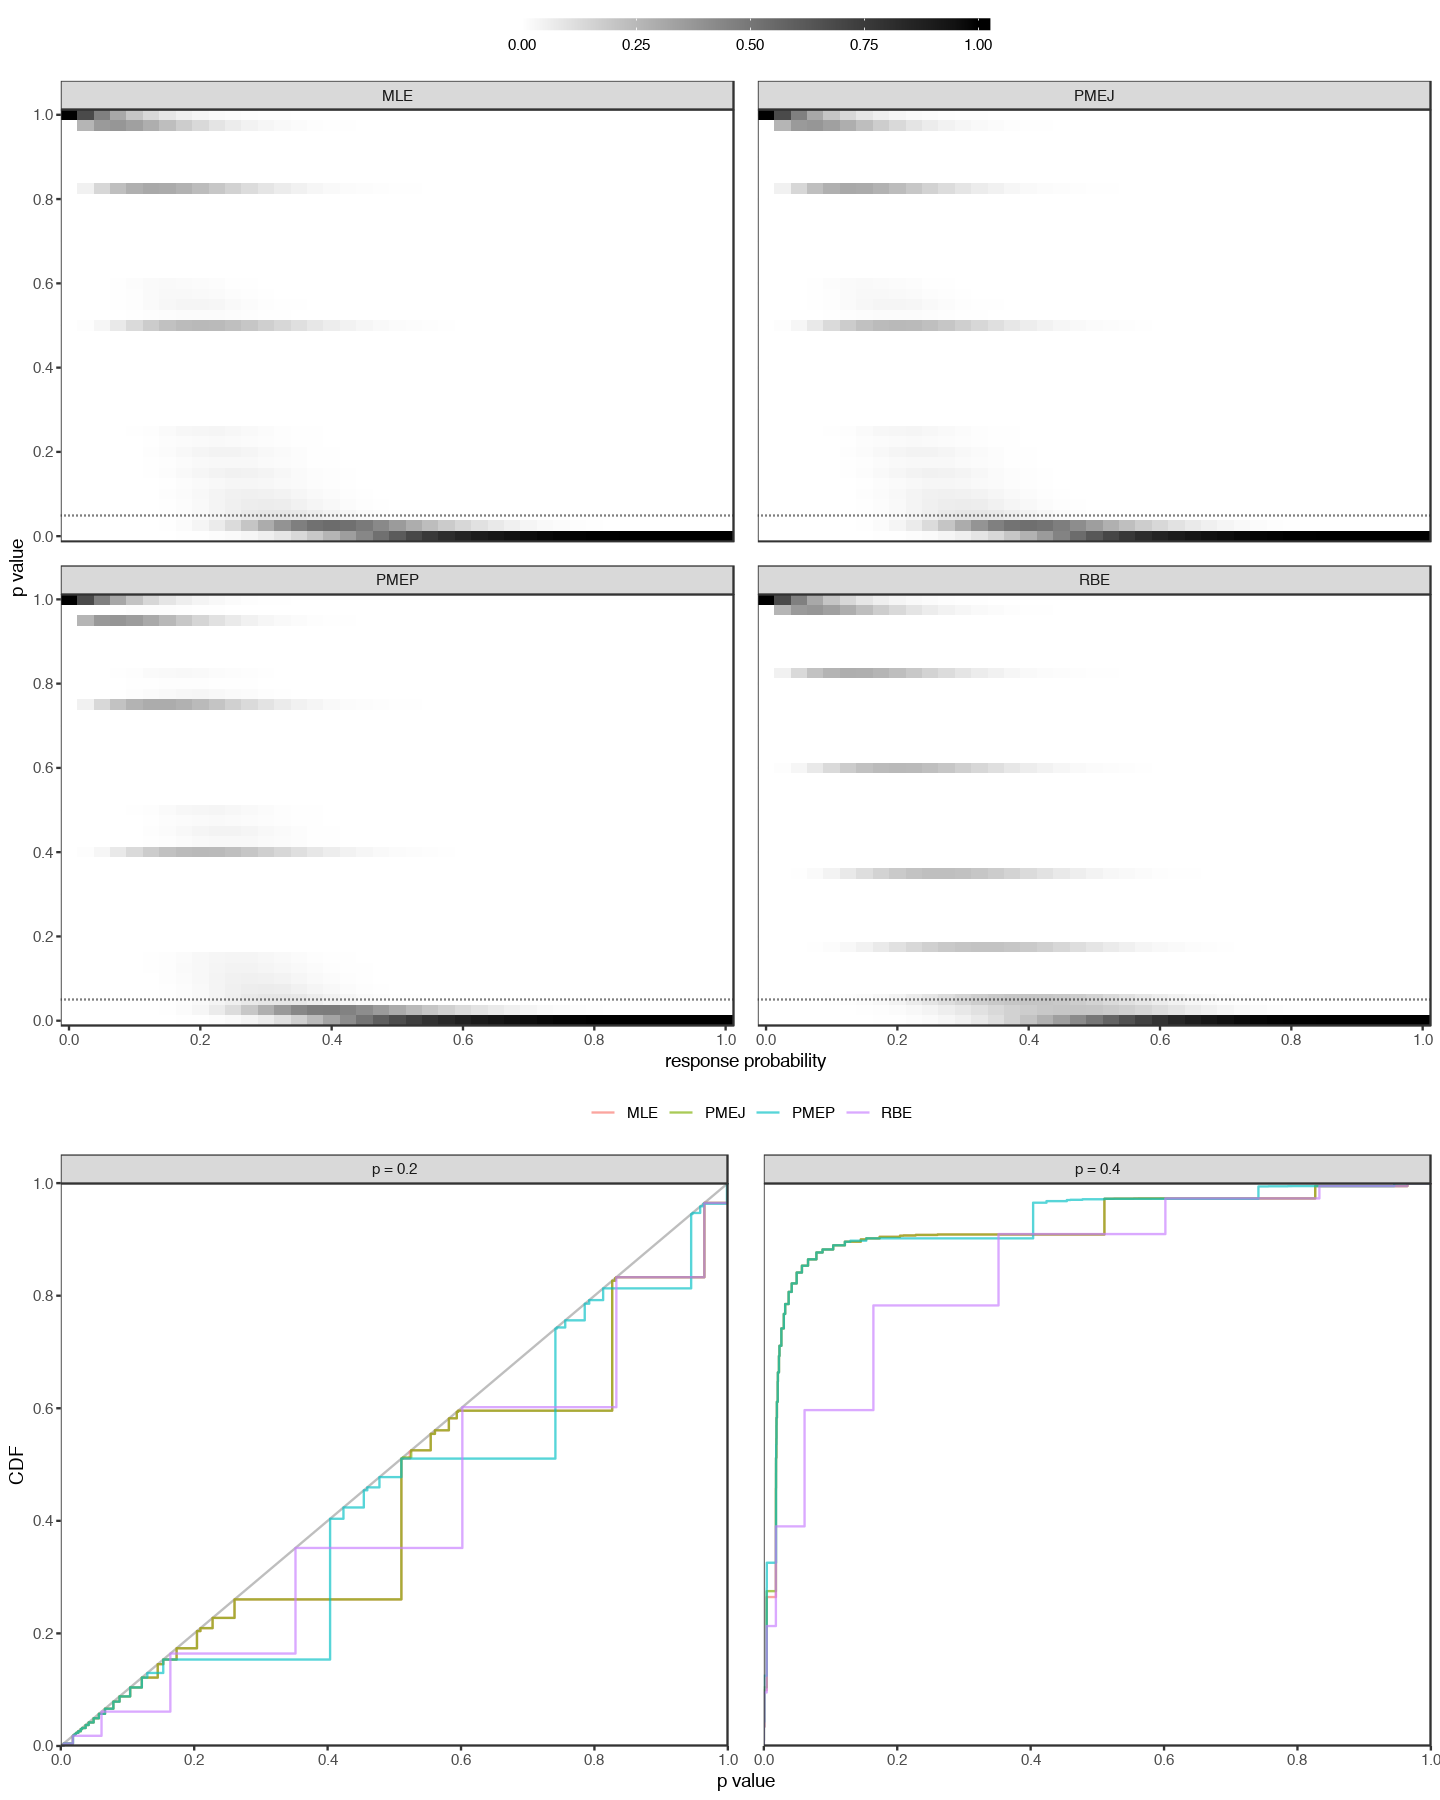

In [35]:
options(repr.plot.width = 12, repr.plot.height = 15)

cowplot::plot_grid(
    plt_pval_density, 
    plt_pval_cdf, 
    ncol = 1, 
    rel_heights = c(3, 2)
)

In [ ]:
ggsave("frequentist-inference-pvalue-distributions.pdf", width = 7, height = 8)

In [36]:
tbl_ci_performance <- expand_grid(
        estimator = tbl_estimators$name,
        p         = seq(0, 1, .01)
    ) %>%
    mutate(
        coverage = map2(p, estimator,
                function(p, estimator_name) {
                    interval <- tbl_estimators %>%
                        filter(name == estimator_name) %>%
                        pull(interval) %>%
                        .[[1]]
                    res <- coverage_probability(interval, p)
                    tibble(coverage = res, type = c("low", "joint", "high"))
                }
            ),
        mean_width = map2_dbl(p, estimator,
                  function(p, estimator_name) {
                      interval <- tbl_estimators %>%
                          filter(name == estimator_name) %>%
                          pull(interval) %>%
                          .[[1]]
                      mean_width(interval, p)
                  }
            )
    ) %>%
    unnest(coverage)

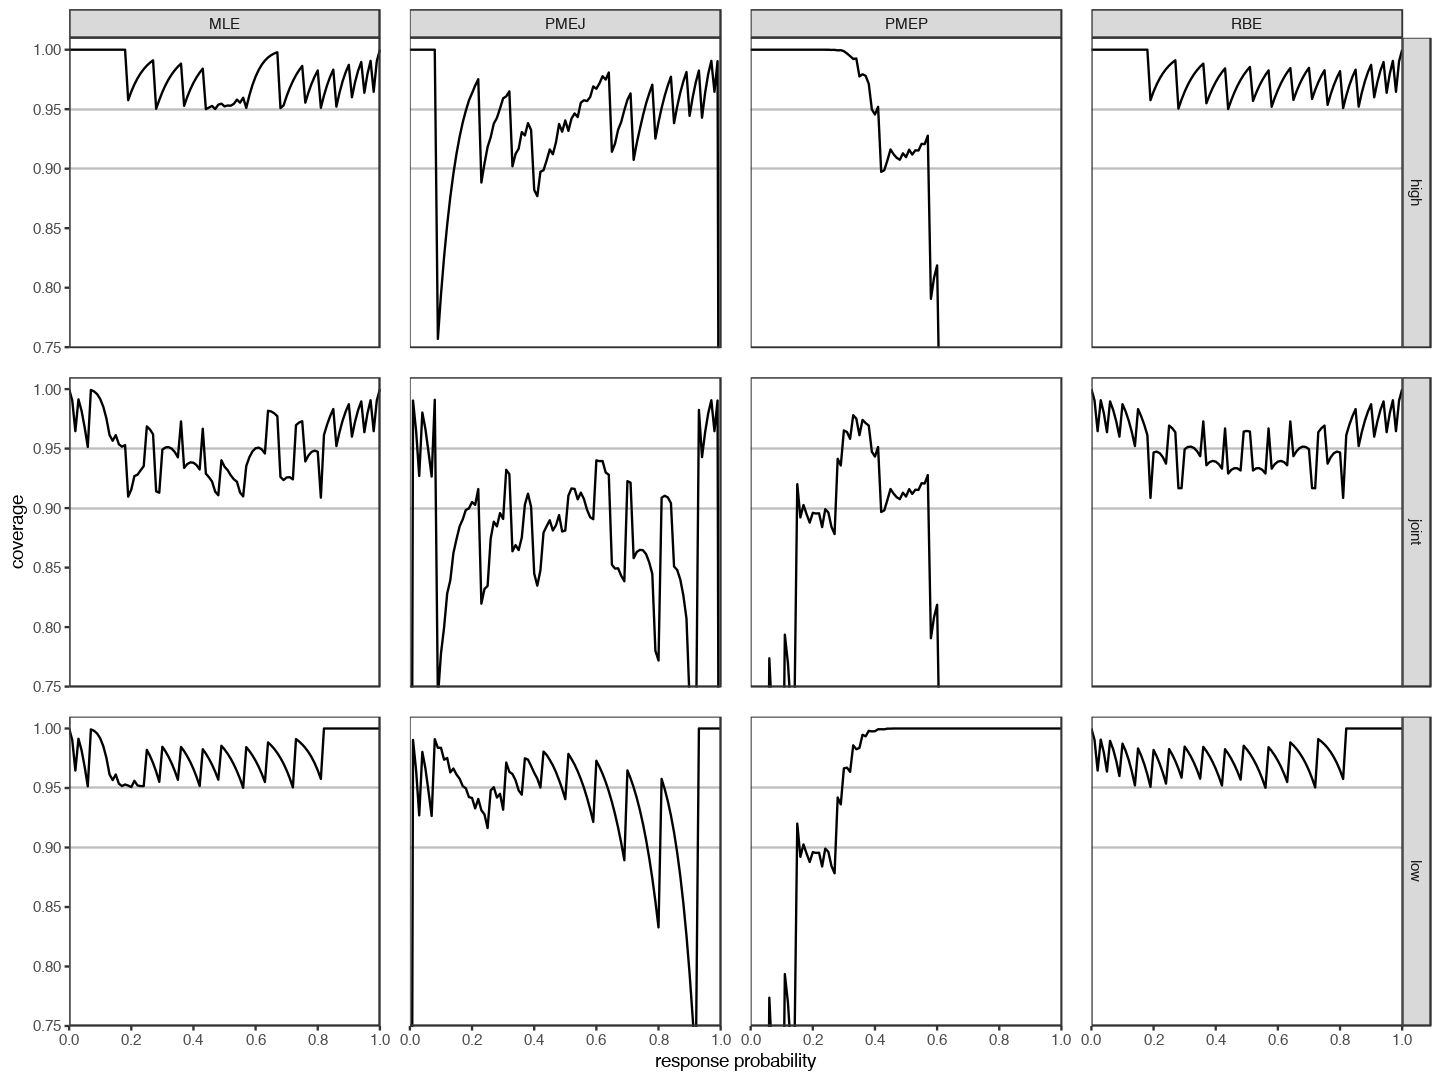

In [39]:
options(repr.plot.width = 12, repr.plot.height = 9)

plt_coverage <- ggplot(tbl_ci_performance, aes(p, coverage) ) +
    geom_hline(yintercept = 1 - alpha, color = "gray") +
    geom_hline(yintercept = 1 - 2*alpha, color = "gray") +
    geom_line() +
    facet_grid(type ~ estimator) +
    scale_color_discrete('') +
    scale_x_continuous('response probability', breaks = seq(0, 1, .2)) +
    scale_y_continuous('coverage', breaks = seq(0, 1, .05)) +
    coord_cartesian(expand = FALSE, ylim = c(0.75, 1.01)) +
    theme_bw() +
    theme(
        legend.position = 'top',
        panel.grid      = element_blank(),
        panel.spacing   = unit(1.25, "lines")
    )

plt_coverage

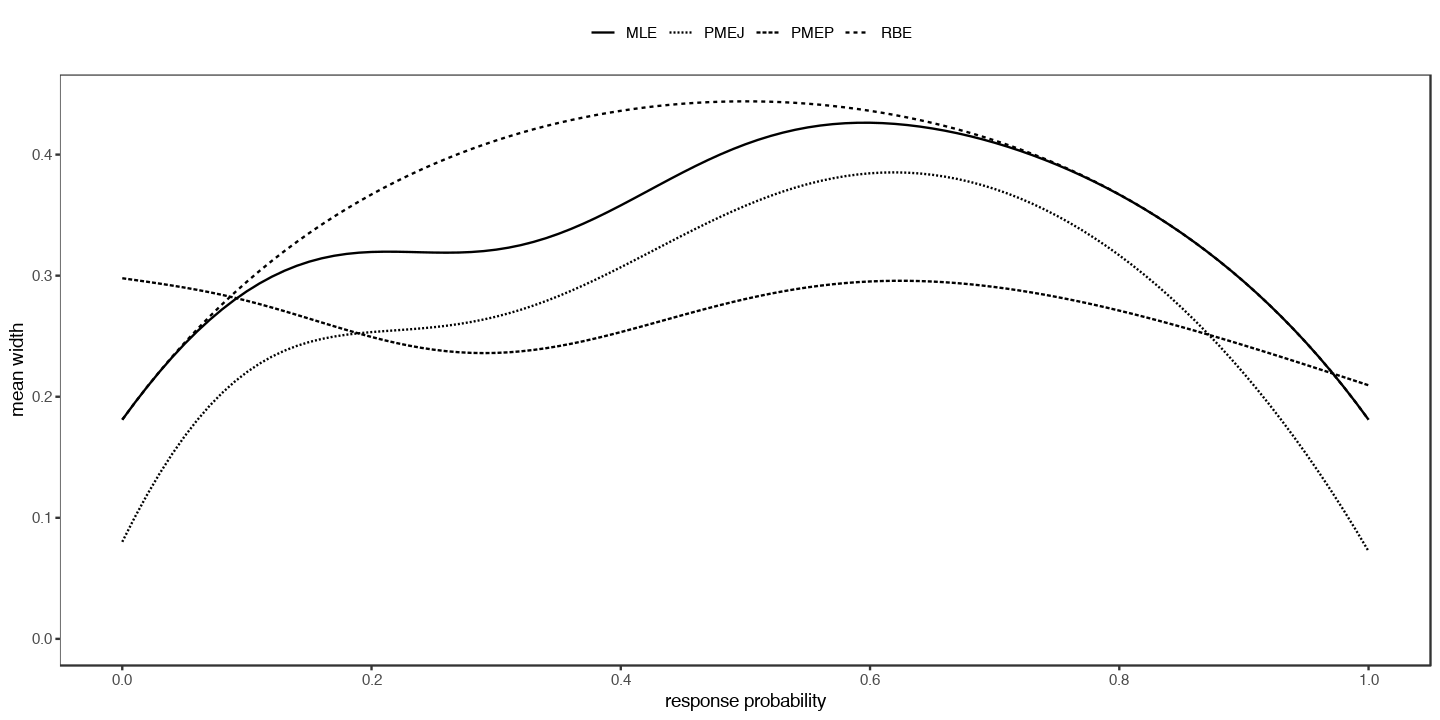

In [40]:
options(repr.plot.width = 12, repr.plot.height = 6)

plt_mean_width <- ggplot(tbl_ci_performance %>% filter(type == 'joint')) +
    aes(p, mean_width) +
    geom_line(aes(linetype = estimator)) +
    scale_linetype_discrete('') +
    scale_x_continuous('response probability', breaks = seq(0, 1, .2)) +
    scale_y_continuous('mean width', limits = c(0, NA)) +
    theme_bw() +
    theme(
        legend.position = 'top',
        panel.grid      = element_blank(),
        panel.spacing   = unit(1, "lines")
    )

plt_mean_width

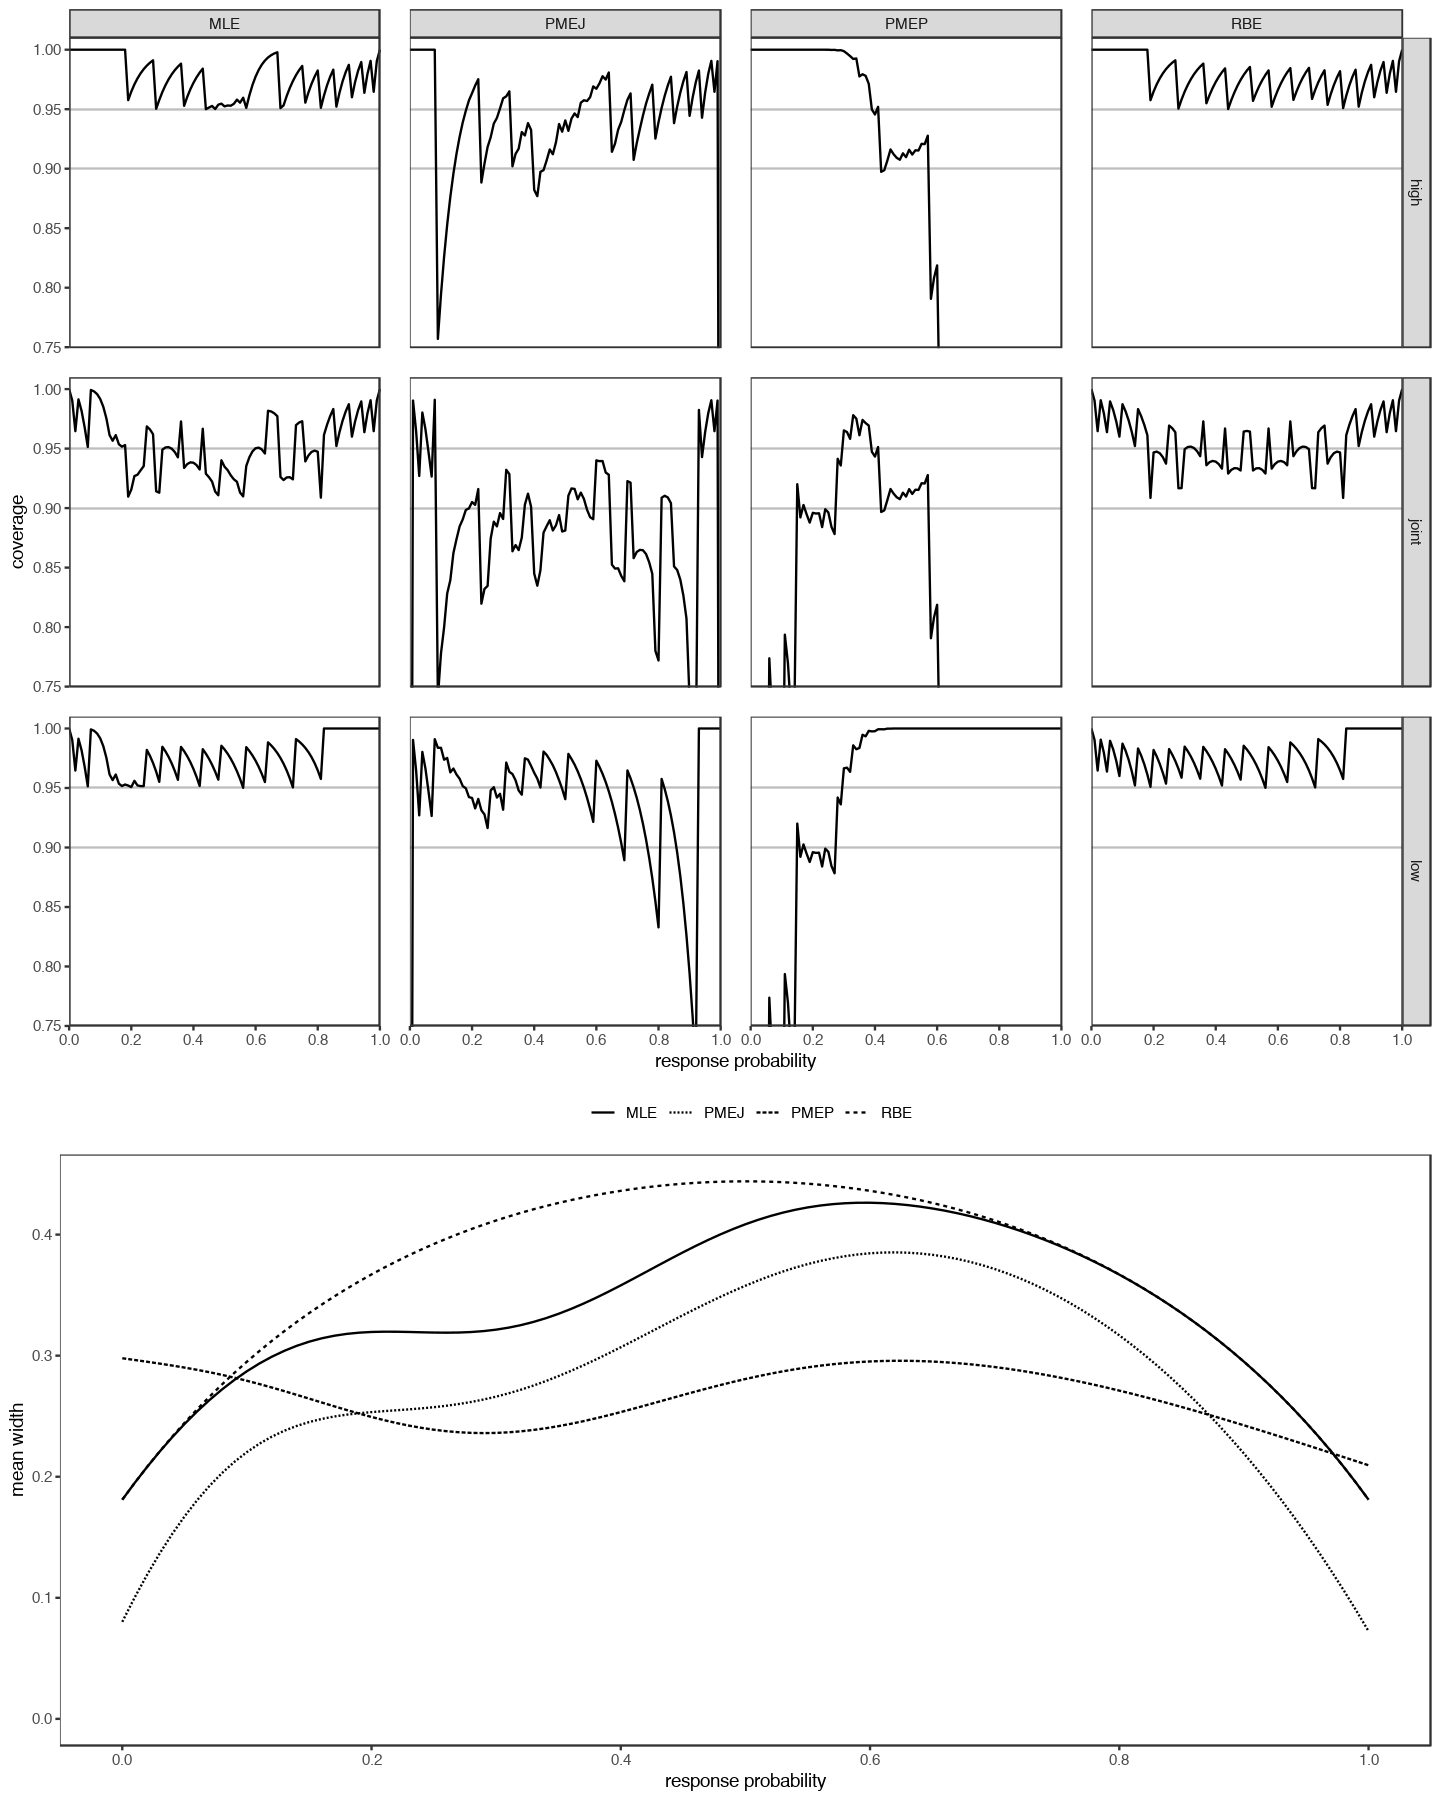

In [41]:
options(repr.plot.width = 12, repr.plot.height = 15)

cowplot::plot_grid(
    plt_coverage, 
    plt_mean_width, 
    ncol = 1, 
    rel_heights = c(3, 2)
)

In [ ]:
ggsave("frequentist-inference-confidence-intervals.pdf", width = 7, height = 8)

## Shan design and incompatibility

In [45]:
p0    <- .6
alpha <- .05
p1    <- .8
beta  <- .1

#  manually construct the corresponding design by Shan et al.
shan_n1 <- 19
shan_continue <- 13:17
shan_n2 <- numeric(shan_n1 + 1)
shan_n2[shan_continue + 1] <- c(33, 31, 31, 31, 14)
shan_c <- rep(Inf, shan_n1 + 1)
shan_c[shan_continue + 1] <- c(36, 35, 35, 35, 22)
shan_c[((max(shan_continue) + 1):shan_n1) + 1] <- -Inf
shan_c2 <- shan_c - 0:shan_n1

design <- Design(shan_n2, shan_c2, label = "Shan")

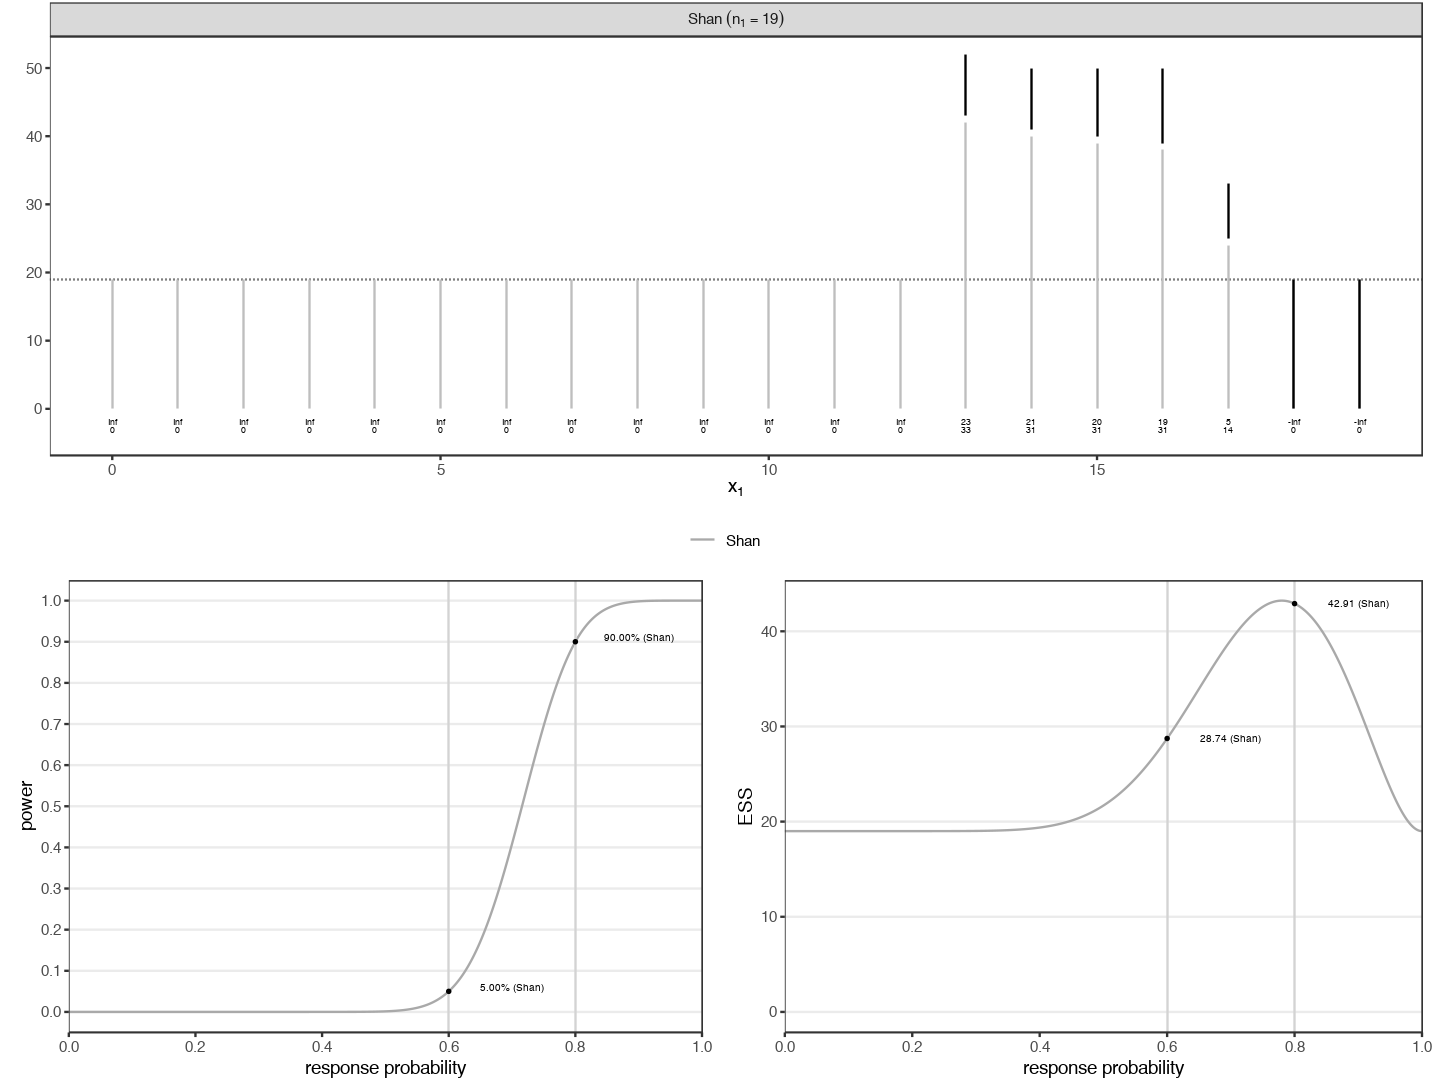

In [46]:
options(repr.plot.width = 12, repr.plot.height = 9)

plt_design <- plot_compare_designs(
    design,
    annotations = c(p0, p1)
)

plt_design

In [47]:
tbl_estimators <- tibble(
        MLE  = list(MaximumLikelihoodEstimator()),
        CMLE = list(CompatibleMLE(design)),
        PMEJ = list(PosteriorMeanPrecalculated(JeffreysPrior(design), design)),
        RBE  = list(RaoBlackwellEstimator())
    ) %>%
    pivot_longer(
        everything(), values_to = 'estimator'
    ) %>%
    mutate(
        pvalue = map(estimator, ~PValue(., design, p0, orientation = 'superiority'))
    )

In [48]:
tbl_performance <- expand_grid(
        estimator = tbl_estimators$name,
        p         = seq(0, 1, .01)
    ) %>%
    mutate(
        data = map2(p, estimator,
            function(p, estimator_name) {
                estimator <- tbl_estimators %>%
                    filter(name == estimator_name) %>%
                    pull(estimator) %>%
                    .[[1]]
                tibble(
                    bias = bias(p, estimator, design),
                    RMSE = sqrt(mean_squared_error(p, estimator, design))
                )
            }
        )
    ) %>%
    unnest(data) %>%
    pivot_longer(c(bias, RMSE), names_to = 'quantity')

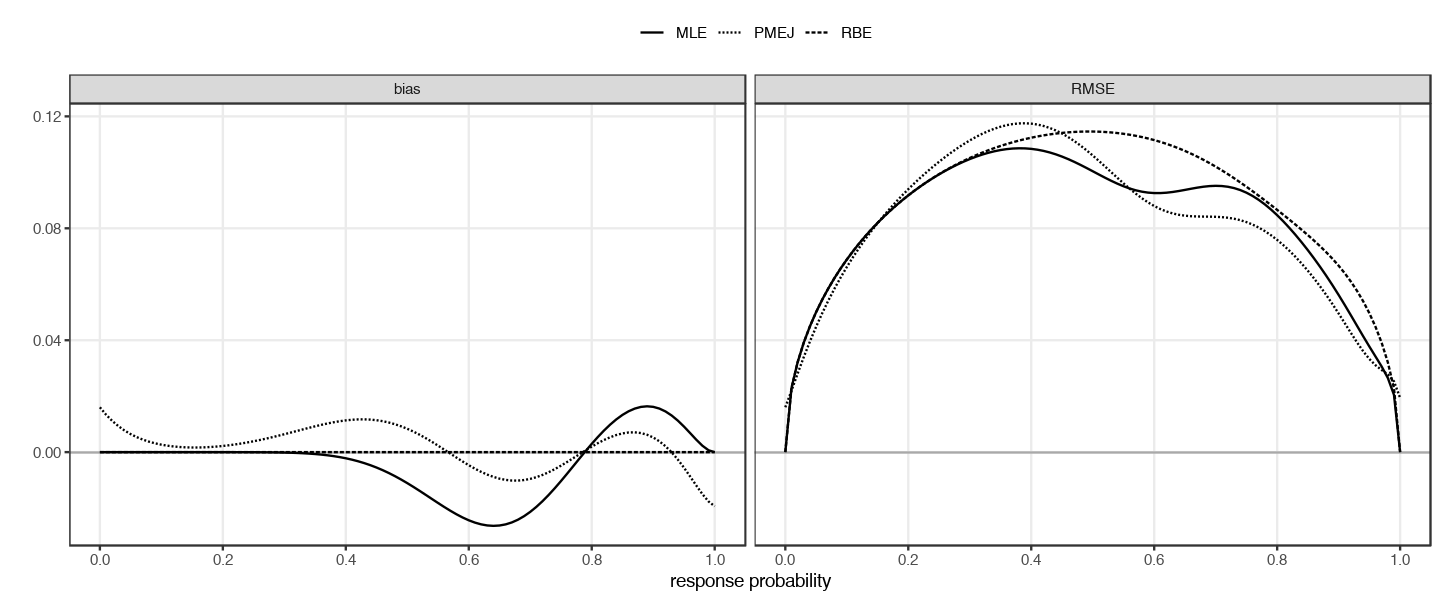

In [51]:
options(repr.plot.width = 12, repr.plot.height = 5)

plt_performance_comparison <- ggplot(tbl_performance %>% filter(estimator != "CMLE")) +
    aes(p, value, linetype = estimator) +
    geom_hline(yintercept = 0, color = 'darkgray') +
    geom_line(size = .5) +
    scale_x_continuous('response probability', breaks = seq(0, 1, .2)) +
    scale_y_continuous('') +
    scale_linetype_discrete('') +
    facet_wrap(~quantity, nrow = 1) +
    theme_bw() +
    theme(
        legend.position  = 'top',
        panel.grid.minor = element_blank(),

    )

plt_comparison

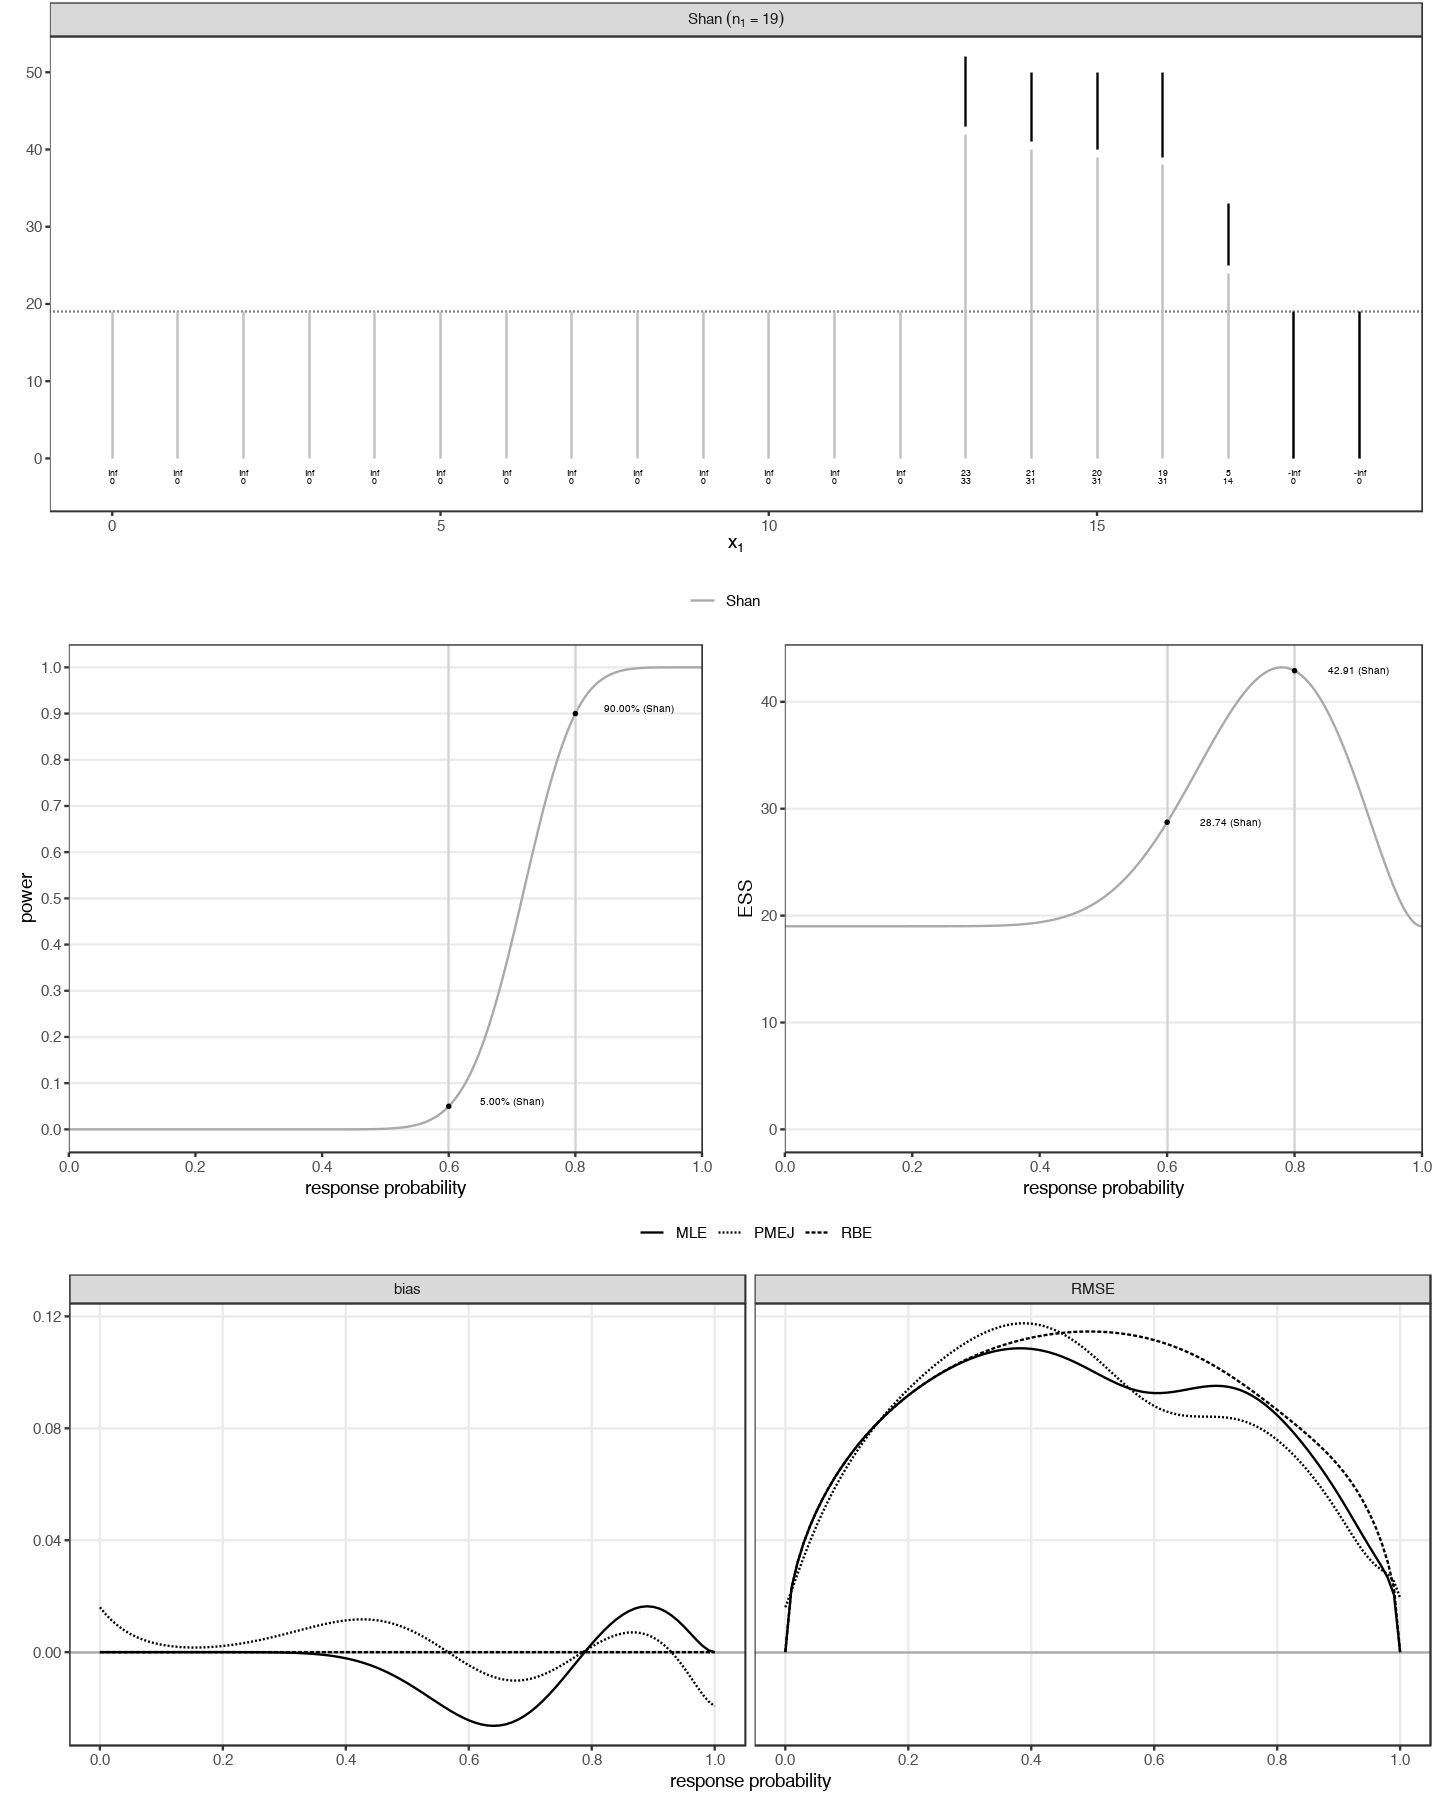

In [54]:
options(repr.plot.width = 12, repr.plot.height = 15)

cowplot::plot_grid(
    plt_design, 
    plt_performance_comparison,
    ncol = 1, 
    rel_heights = c(2, 1)
)

In [55]:
ggsave("frequentist-inference-shan-design-performance.pdf", width = 7, height = 8)

In [56]:
XX <- sample_space(design)

In [57]:
tbl_compatibility <- XX %>%
    mutate(
        name      = list(tbl_estimators$name),
        estimator = list(tbl_estimators$estimator),
        pvalue    = list(tbl_estimators$pvalue)
    ) %>%
    unnest(c(name, estimator, pvalue)) %>%
    mutate(
        estimate = pmap( list(x1, x2, estimator), ~estimate(..3, ..1, ..2, design) ),
        p_value  = pmap( list(x1, x2, pvalue), ~get_p(..3, ..1, ..2) ),
        reject   = map2(x1, x2, ~reject(..1, ..2, design))
    ) %>%
    unnest(c(estimate, p_value, reject))

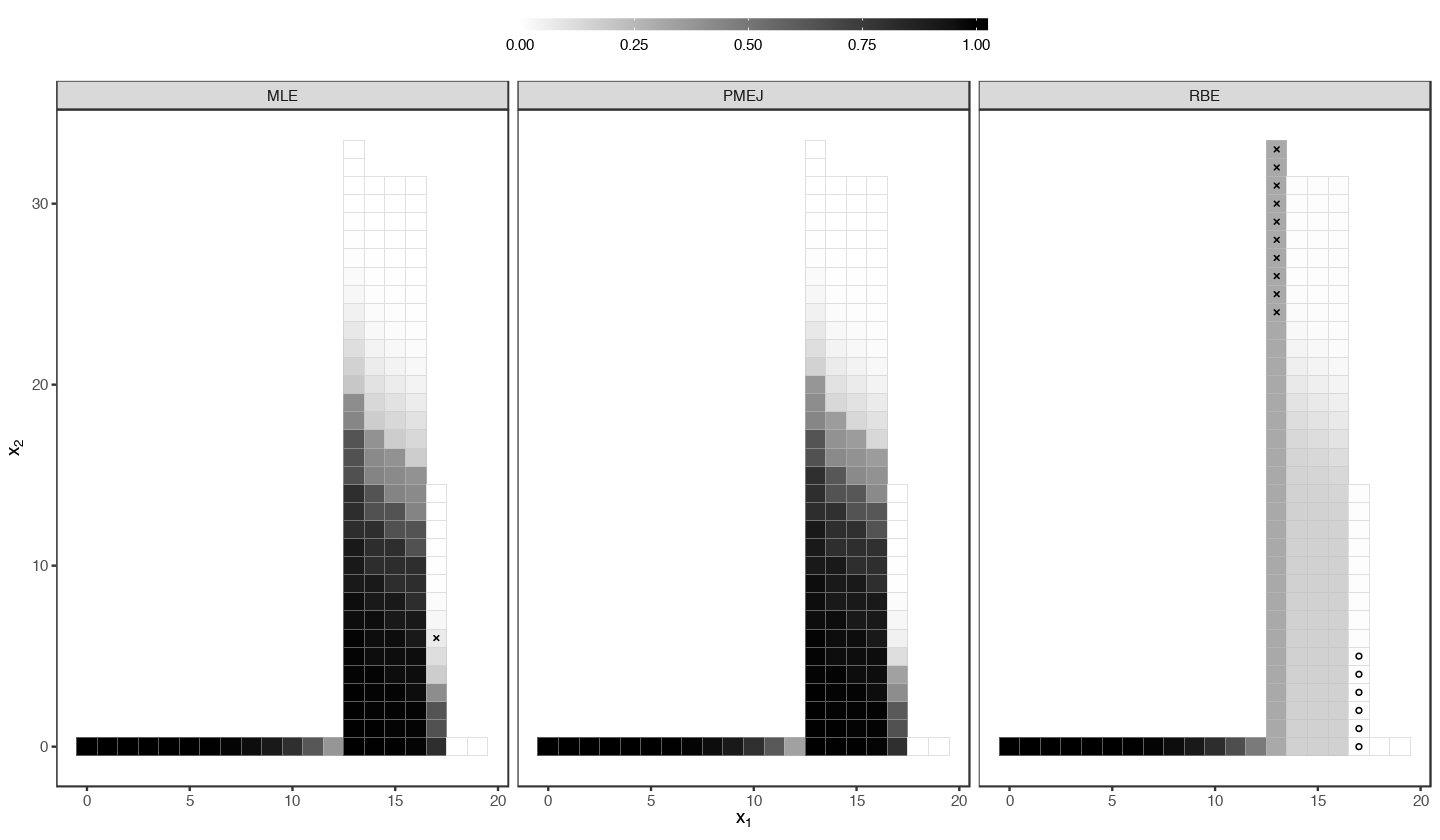

In [68]:
options(repr.plot.width = 12, repr.plot.height = 7)

ggplot(tbl_compatibility %>% filter(name != "CMLE")) +
    aes(x1, x2) +
    geom_tile(aes(fill = p_value), color = 'gray', width = 1, height = 1) +
    geom_point(shape = 4, size = 1,
               data = filter(tbl_compatibility, p_value > alpha, reject)) +
    geom_point(shape = 1, size = 1,
               data = filter(tbl_compatibility, p_value <= alpha, !reject)) +
    scale_fill_gradient('', low = 'white', high = 'black', limits = c(0, NA)) +
    scale_x_continuous(expression(x[1])) +
    scale_y_continuous(expression(x[2])) +
    facet_wrap(~name) +
    theme_bw() +
    theme(
        panel.grid        = element_blank(),
        legend.position   = 'top',
        legend.key.width  = grid::unit(4, 'lines'),
        legend.key.height = grid::unit(.5, 'lines')
    )

In [70]:
ggsave("frequentist-inference-shan-design-incompatibility.pdf", width = 7, height = 4)

In [63]:
tbl_cmle_mle_diff <- tbl_compatibility %>%
    filter(name %in% c("MLE", "CMLE")) %>%
    select(x1, x2, name, estimate) %>%
    arrange(x1, x2, name) %>%
    group_by(x1, x2) %>%
    summarize(delta_CMLE_minus_MLE = diff(estimate)) %>%
    ungroup()

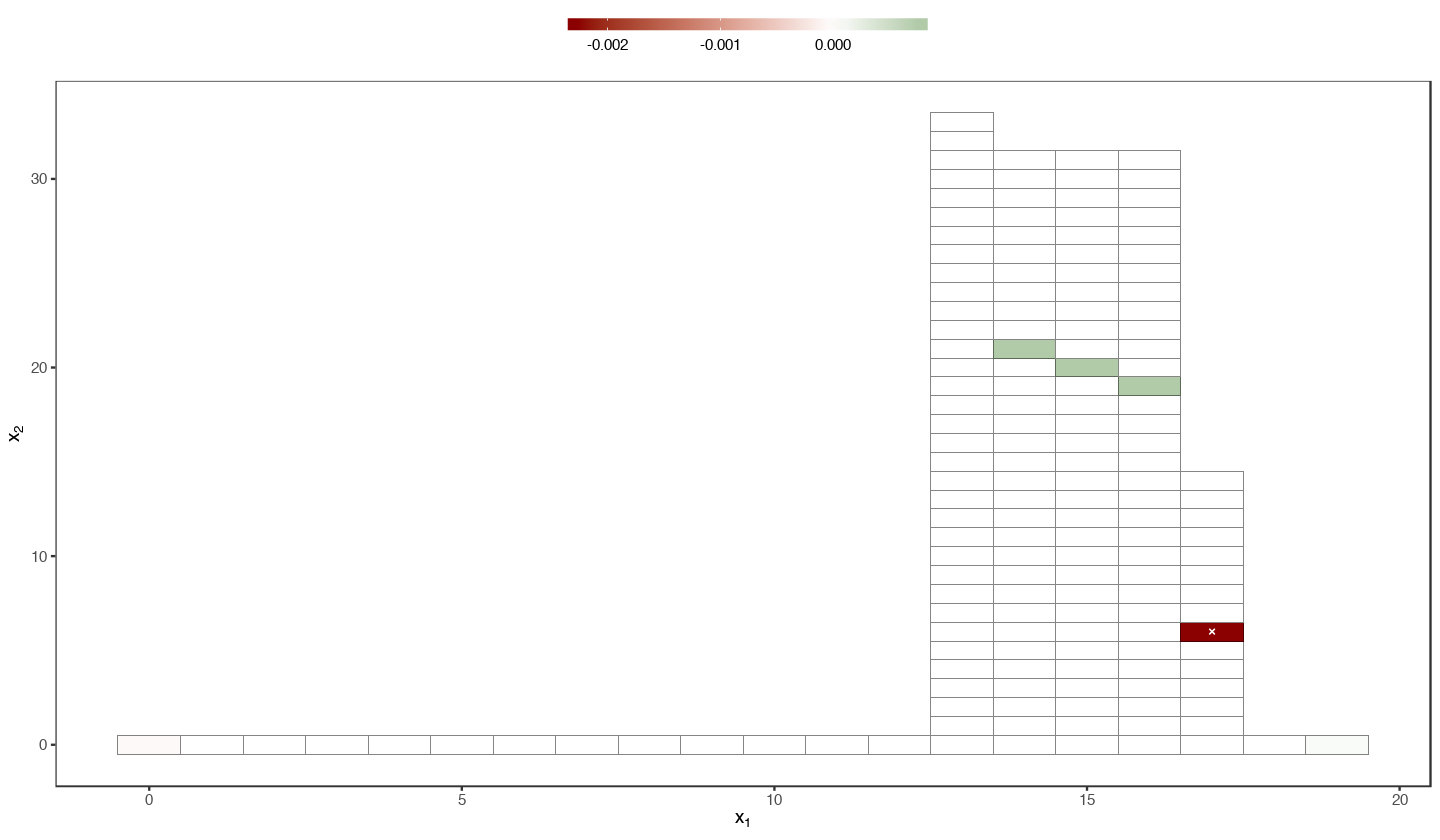

In [64]:
options(repr.plot.width = 12, repr.plot.height = 7)

ggplot(tbl_cmle_mle_diff) +
    aes(x1, x2) +
    geom_tile(aes(fill = delta_CMLE_minus_MLE), color = 'black', width = 1, height = 1) +
    geom_point(shape = 4, size = 1, color = 'white',
               data = filter(tbl_compatibility, name == "MLE", p_value > alpha, reject)) +
    geom_point(shape = 1, size = 1, color = 'white',
               data = filter(tbl_compatibility, name == "MLE", p_value <= alpha, !reject)) +
    scale_fill_gradient2('', low = 'darkred', mid = 'white', high = 'darkgreen', limits = c(NA, NA)) +
    scale_x_continuous(expression(x[1])) +
    scale_y_continuous(expression(x[2])) +
    theme_bw() +
    theme(
        panel.grid        = element_blank(),
        legend.position   = 'top',
        legend.key.width  = grid::unit(3, 'lines'),
        legend.key.height = grid::unit(.5, 'lines')
    )

In [66]:
ggsave("frequentist-inference-shan-design-cmle-difference.pdf", width = 7, height = 6)

### Check occurence of Incompatibility with MLE

explore incompatibility degree (number of incompatibilities) for a set of standard designs.

In [82]:
for (pp0 in seq(0.1, 0.7, 0.1)) {
    for (p in c(pp0, pp0 + .2)) {
        Problem(
            minimise( SampleSize(PointMass(p)) ),
            Power(PointMass(pp0)) <= alpha,
            Power(PointMass(pp0 + .2)) >= 1 - beta
        ) %>%
        optimise_design(verbosity = 0) %>%
        mle_compatible(pp0, alpha) %>%
        {.$`incompatibility degree`} %>%
        {sprintf("p0=%.2f, ESS minimised under %.2f; incompatibility degree: %i\n\r", pp0, p, .)} %>%
        cat()
    }
}

p0=0.10, ESS minimised under 0.10; incompatibility degree: 0
p0=0.10, ESS minimised under 0.30; incompatibility degree: 0
p0=0.20, ESS minimised under 0.20; incompatibility degree: 0
p0=0.20, ESS minimised under 0.40; incompatibility degree: 0
p0=0.30, ESS minimised under 0.30; incompatibility degree: 0
p0=0.30, ESS minimised under 0.50; incompatibility degree: 0
p0=0.40, ESS minimised under 0.40; incompatibility degree: 0
p0=0.40, ESS minimised under 0.60; incompatibility degree: 0
p0=0.50, ESS minimised under 0.50; incompatibility degree: 0
p0=0.50, ESS minimised under 0.70; incompatibility degree: 0
p0=0.60, ESS minimised under 0.60; incompatibility degree: 0
p0=0.60, ESS minimised under 0.80; incompatibility degree: 0
p0=0.70, ESS minimised under 0.70; incompatibility degree: 1
p0=0.70, ESS minimised under 0.90; incompatibility degree: 0
